## Simulation of the Heston model using the Quadratic exponential scheme

In order to achieve maximum performance of Pytorch in a Monte-Carlo simulation it is critical to vectorize over the number of simulations. Thus we need to remove all 'if' statements from the Quadratic Exponential scheme.

In [52]:
import torch
import numpy as np
from icecream import ic

In [63]:
paths =2**5-1
n_dt = 32

In [64]:
rho = torch.tensor(-0.15, requires_grad=True)
theta = torch.tensor((0.25)**2, requires_grad=True)
kappa = torch.tensor(1., requires_grad=True)
eta= torch.tensor(2., requires_grad=True)
T = 1
dt = T/n_dt
dim = n_dt-1

In [65]:
V = torch.zeros([n_dt,paths])
Vt = torch.zeros([paths])
Vt[:] = theta
V[0] = theta
Vt

tensor([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
        0.0625, 0.0625, 0.0625, 0.0625], grad_fn=<CopySlices>)

In [66]:
sobol_engine =  torch.quasirandom.SobolEngine(dim)
x = sobol_engine.draw(15)

In [67]:
u = sobol_engine.draw(paths,dtype=torch.float64)

In [68]:
u = torch.transpose(u,0,1)
u[0]

tensor([0.0625, 0.0938, 0.5938, 0.8438, 0.3438, 0.4688, 0.9688, 0.7188, 0.2188,
        0.1562, 0.6562, 0.9062, 0.4062, 0.2812, 0.7812, 0.5312, 0.0312, 0.0469,
        0.5469, 0.7969, 0.2969, 0.4219, 0.9219, 0.6719, 0.1719, 0.2344, 0.7344,
        0.9844, 0.4844, 0.3594, 0.8594], dtype=torch.float64)

In [69]:
from quant_analytics_torch.analytics.norminv import norminv
from quant_analytics_torch.analytics import maxsoft

In [70]:
for i in range(n_dt-1):
    minusexpkappadt = torch.exp(-kappa*dt)
    m = theta+( Vt - theta) * minusexpkappadt
    s2 = ((Vt*eta**2) * minusexpkappadt/kappa)*(1-minusexpkappadt) + ( theta*eta**2)*((1-minusexpkappadt)**2)/(2*kappa)
    phi = s2/m**2
    #
    # Calculate the lower branch
    #
    b2 = torch.maximum((2/phi)-1+2*(torch.sqrt(2/phi))*(torch.sqrt(torch.maximum(-1+2/phi, torch.tensor(0.)))),torch.tensor(0.))
    a = m/(1+b2)
    z = norminv(u[i])
    Vnew_1 = a*(z + b2**0.5)**2
    #
    # Calulcate the upper branch
    #
    p = (phi-1)/(phi+1)
    beta = 2/(m+m*phi)
    Vnew_2 = torch.log((1-p)/(1-u[i])) / beta
    Vnew_2 = torch.maximum(Vnew_2, torch.tensor(0.))
    phiC = 1.5
    #
    # Switch the branches
    #
    p_1 = maxsoft.soft_heavy_side_hyperbolic(phiC-phi)
    q_1 = 1. - p_1
    Vt = p_1 * Vnew_1 + q_1 * Vnew_2
    V[i+1] = Vt
V


tensor([[6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02,
         6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02,
         6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02,
         6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02,
         6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02, 6.2500e-02,
         6.2500e-02],
        [0.0000e+00, 0.0000e+00, 4.7382e-02, 1.3513e-01, 3.3396e-03, 2.2746e-02,
         2.8294e-01, 8.1153e-02, 0.0000e+00, 0.0000e+00, 6.2724e-02, 1.8205e-01,
         1.2531e-02, 0.0000e+00, 1.0423e-01, 3.4240e-02, 0.0000e+00, 0.0000e+00,
         3.7354e-02, 1.1104e-01, 0.0000e+00, 1.4980e-02, 1.9879e-01, 6.6996e-02,
         0.0000e+00, 0.0000e+00, 8.6402e-02, 3.4660e-01, 2.5487e-02, 5.5527e-03,
         1.4481e-01],
        [0.0000e+00, 0.0000e+00, 2.4427e-01, 4.2762e-02, 0.0000e+00, 0.0000e+00,
         2.9083e-01, 1.9657e-02, 0.0000e+00, 0.0000e+00, 6.3007e-

In [71]:
import matplotlib
from matplotlib import pyplot as plt

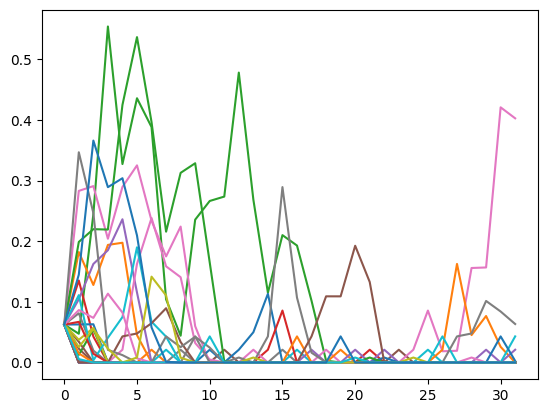

In [72]:
plt.plot(V.detach().numpy()[:,:])